In [1]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from tqdm import tqdm


In [2]:
torch.manual_seed(420)

In [3]:
DATASET_ROOT = 'dataset'
A_DIR = os.path.join(DATASET_ROOT, 'a')
B_DIR = os.path.join(DATASET_ROOT, 'b')
C_DIR = os.path.join(DATASET_ROOT, 'c')
D_DIR = os.path.join(DATASET_ROOT, 'd')

DOG_CLASS_INDEX = 12  # VOC dog class index

In [4]:
# Item A: one example image and mask
item_a_img = os.path.join(A_DIR, 'img.jpg')
item_a_mask = os.path.join(A_DIR, 'mask.png')

# Item B: class description
with open(os.path.join(B_DIR, 'class.txt'), 'r') as f:
    item_b_text = f.read().strip()

# Item C: unlabeled images
item_c_imgs = [os.path.join(C_DIR, fname) for fname in os.listdir(C_DIR) if fname.lower().endswith('.jpg')]

# Item D: test images and masks
item_d_imgs = sorted([os.path.join(D_DIR, fname) for fname in os.listdir(D_DIR) if fname.lower().endswith('.jpg')])
item_d_masks = [img.replace('.jpg', '_mask.png') for img in item_d_imgs]

In [5]:
import open_clip

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
clip_model = clip_model.to(device)
tokenizer = open_clip.get_tokenizer('ViT-B-32')

def clip_predict(img_path, text):
    image = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
    text = tokenizer([text]).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image)
        text_features = clip_model.encode_text(text)
        logits_per_image = (image_features @ text_features.T).squeeze()
    return logits_per_image.item()

In [6]:
clip_scores = [clip_predict(img, item_b_text) for img in item_c_imgs]
threshold = np.percentile(clip_scores, 80)  # Top 20% as likely
likely_dog_imgs = [img for img, score in zip(item_c_imgs, clip_scores) if score >= threshold]
print(f"Selected {len(likely_dog_imgs)} pseudo-labeled images.")

Selected 32 pseudo-labeled images.


In [7]:
from segment_anything import sam_model_registry, SamPredictor
sam_checkpoint = "sam_vit_b_01ec64.pth"  # Download from SAM repo
sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
sam = sam.to(device)
predictor = SamPredictor(sam)

def sam_generate_mask(img_path, prompt_point=None):
    image = np.array(Image.open(img_path))
    predictor.set_image(image)
    if prompt_point is None:
        h, w = image.shape[:2]
        prompt_point = np.array([[w//2, h//2]])
        prompt_label = np.array([1])
    else:
        prompt_label = np.array([1])
    masks, scores, _ = predictor.predict(
        point_coords=prompt_point,
        point_labels=prompt_label,
        multimask_output=True,
    )
    best_mask = masks[np.argmax(scores)]
    return best_mask


In [8]:
pseudo_label_dir = os.path.join(DATASET_ROOT, 'pseudo_labels')
os.makedirs(pseudo_label_dir, exist_ok=True)
for img_path in likely_dog_imgs:
    mask = sam_generate_mask(img_path)
    mask_img = Image.fromarray((mask * 255).astype(np.uint8))
    mask_img.save(os.path.join(pseudo_label_dir, os.path.basename(img_path).replace('.jpg', '_mask.png')))

In [9]:
class PseudoLabeledDataset(Dataset):
    def __init__(self, image_paths, mask_paths, processor):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx])
        # For pseudo-labels from SAM, just threshold
        mask = np.array(mask)
        mask = np.where(mask > 127, 1, 0).astype(np.uint8)
        mask = Image.fromarray(mask)
        inputs = self.processor(images=image, segmentation_maps=mask, return_tensors="pt")
        inputs = {k: v.squeeze() for k, v in inputs.items()}
        return inputs

In [10]:
processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
pseudo_label_paths = [os.path.join(pseudo_label_dir, os.path.basename(img).replace('.jpg', '_mask.png')) for img in likely_dog_imgs]
dataset = PseudoLabeledDataset(likely_dog_imgs, pseudo_label_paths, processor)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

/home/scai/mtech/aib242289/.conda/envs/cv/lib/python3.12/site-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


In [11]:
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=2,  # Background & dog
    ignore_mismatched_sizes=True
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
model.train()
for epoch in range(40):  # Adjust epochs as needed
    loop = tqdm(dataloader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].long().to(device)
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())


Epoch 40: 100%|█████████████████████| 8/8 [00:01<00:00,  7.67it/s, loss=0.00177]


In [13]:
model.save_pretrained(os.path.join(DATASET_ROOT, "finetuned_segformer_dog"))
processor.save_pretrained(os.path.join(DATASET_ROOT, "finetuned_segformer_dog"))


['dataset/finetuned_segformer_dog/preprocessor_config.json']

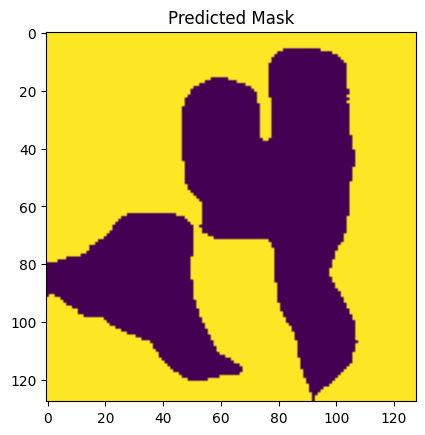

In [14]:
model.eval()
with torch.no_grad():
    for batch in dataloader:
        pixel_values = batch["pixel_values"].to(device)
        outputs = model(pixel_values=pixel_values)
        preds = outputs.logits.argmax(dim=1)
        break

plt.imshow(preds[0].cpu().numpy())
plt.title("Predicted Mask")
plt.show()

In [15]:
def compute_iou(pred_mask, true_mask, num_classes=2):
    ious = []
    for cls in range(num_classes):
        pred_inds = (pred_mask == cls)
        true_inds = (true_mask == cls)
        intersection = (pred_inds & true_inds).sum().item()
        union = (pred_inds | true_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))  # Ignore this class
        else:
            ious.append(intersection / union)
    return ious

def pixel_accuracy(pred_mask, true_mask):
    correct = (pred_mask == true_mask).sum().item()
    total = true_mask.numel()
    return correct / total

def evaluate(model, img_list, mask_list, processor, device):
    model.eval()
    iou_list = []
    pixel_acc_list = []

    with torch.no_grad():
        for img_path, mask_path in zip(img_list, mask_list):
            image = Image.open(img_path).convert("RGB")
            true_mask = Image.open(mask_path)
            true_mask = np.array(true_mask)
            # Binarize for dog class (12)
            true_mask = np.where(true_mask == DOG_CLASS_INDEX, 1, 0).astype(np.uint8)
            true_mask_tensor = torch.tensor(true_mask, dtype=torch.int64)
            # Prepare model input
            inputs = processor(images=image, return_tensors="pt")
            pixel_values = inputs.pixel_values.to(device)
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            pred_mask = torch.argmax(logits.squeeze(), dim=0).cpu()

            # Resize true mask to match prediction if needed
            if true_mask_tensor.shape != pred_mask.shape:
                from torchvision.transforms import functional as F
                true_mask_pil = Image.fromarray(true_mask_tensor.numpy().astype(np.uint8))
                true_mask_resized = F.resize(true_mask_pil, pred_mask.shape, interpolation=Image.NEAREST)
                true_mask_tensor = torch.tensor(np.array(true_mask_resized), dtype=torch.int64)

            # Compute metrics
            ious = compute_iou(pred_mask, true_mask_tensor, num_classes=2)
            iou_list.append(ious)
            pixel_acc = pixel_accuracy(pred_mask, true_mask_tensor)
            pixel_acc_list.append(pixel_acc)

    # Compute mean IoU ignoring NaNs
    iou_array = np.array(iou_list)
    mean_iou_per_class = np.nanmean(iou_array, axis=0)
    mean_iou = np.nanmean(mean_iou_per_class)
    mean_pixel_acc = np.mean(pixel_acc_list)
    return {"miou": mean_iou, "miou_per_class": mean_iou_per_class.tolist(), "pixel_acc": mean_pixel_acc}

metrics = evaluate(model, item_d_imgs, item_d_masks, processor, device)
print("mIoU:", metrics['miou'], "Pixel Accuracy:", metrics['pixel_acc'])

# %%
# Visualize Item A and a few test images/mask

mIoU: 0.11229240924816937 Pixel Accuracy: 0.22311019897460938


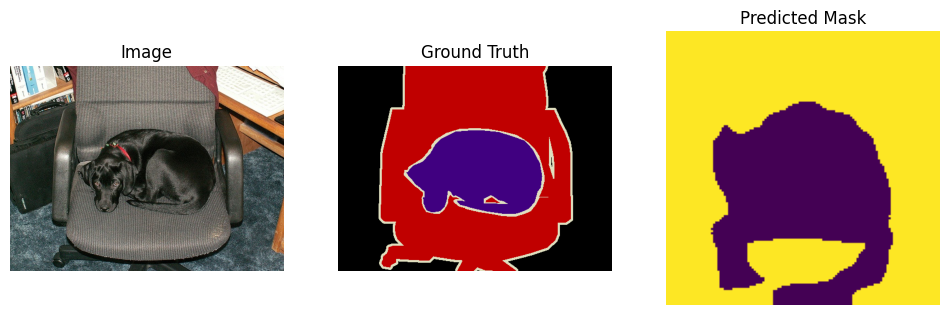

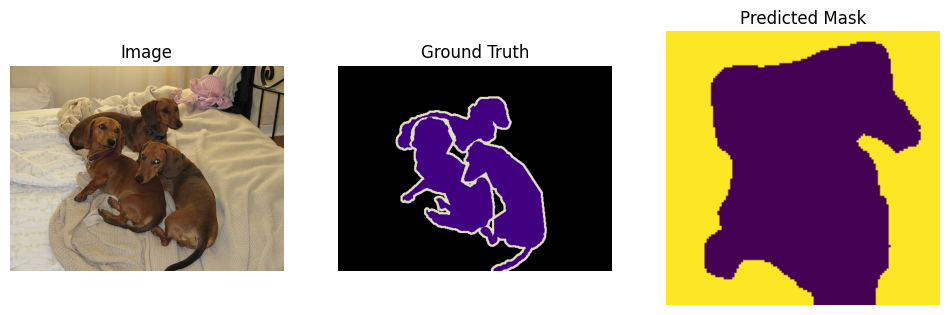

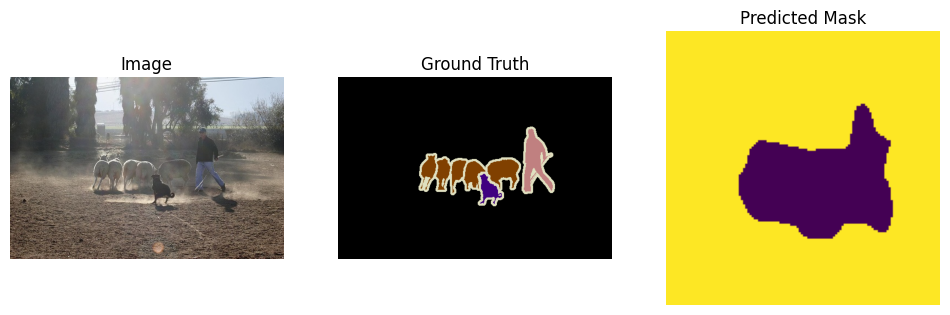

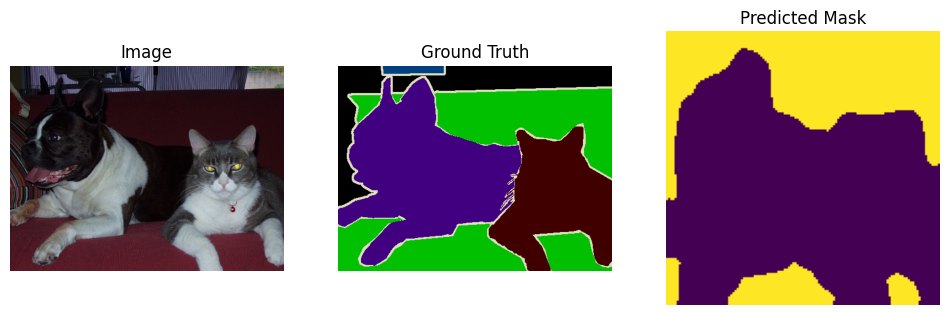

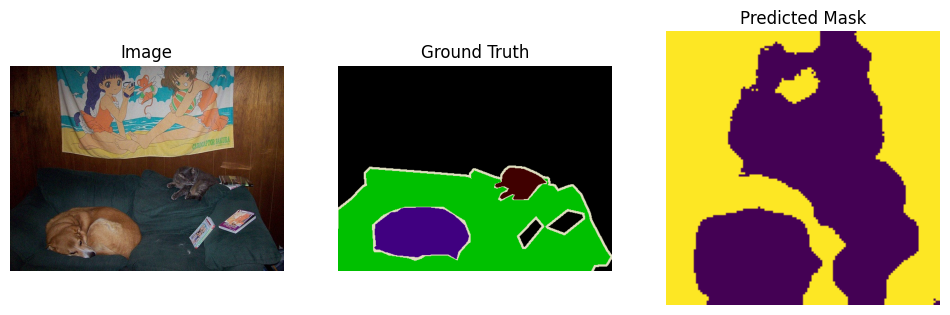

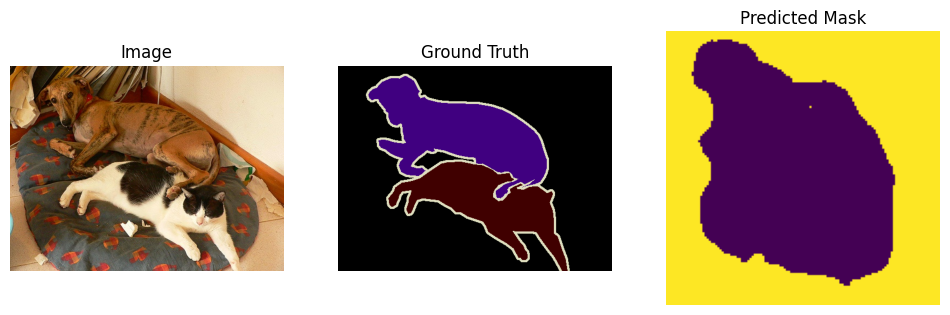

: 

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

def show_img_gt_pred(img_path, mask_path, model, processor, device):
    # Load image and ground truth mask
    img = Image.open(img_path).convert("RGB")
    gt_mask = Image.open(mask_path)
    
    # Prepare input and get model prediction
    inputs = processor(images=img, return_tensors="pt")
    pixel_values = inputs.pixel_values.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        pred_mask = torch.argmax(outputs.logits.squeeze(), dim=0).cpu().numpy()
    
    # Plot all three
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title('Image'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(gt_mask); plt.title('Ground Truth'); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(pred_mask); plt.title('Predicted Mask'); plt.axis('off')
    plt.show()

# Example: visualize Item A
show_img_gt_pred(item_a_img, item_a_mask, model, processor, device)

# Example: visualize first 5 test images
for img_path, mask_path in zip(item_d_imgs[:5], item_d_masks[:5]):
    show_img_gt_pred(img_path, mask_path, model, processor, device)
